# Imports

In [1]:
import pyxdf
import pandas as pd
import numpy as np
import sounddevice as sd
from glob import glob
from tqdm import tqdm
import datetime
import re
import matplotlib.pyplot as plt

# Globals

In [2]:
sub_files = glob('../*/*.xdf')
def get_event_data(event, df, stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]

def get_secs_between_triggers(trigger1, trigger2, stim_df):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]

events = {
    200: 'Onset_Experiment',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_Experiment',
}

story_onsets = [20, 30, 40, 50, 60, 70]

# hist of euclidian distances between left and right eye gaze points

In [8]:
def gaze_point_histogram(pt_number, ax):
    # load data
    xdf_path = sub_files[pt_number]
    data, header = pyxdf.load_xdf(xdf_path)
    streams_collected = [stream['info']['name'][0] for stream in data]

    # ET data
    ET = data[streams_collected.index('Tobii')]
    et_dat = ET['time_series']
    column_labels = [ET['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(ET['info']['desc'][0]['channels'][0]['channel']))]

    et_df = pd.DataFrame(data=et_dat, columns=column_labels)
    et_df['lsl_time_stamp'] = ET['time_stamps']
    et_df['time'] = (ET['time_stamps'] - ET['time_stamps'][0])/1000

    # stim
    stim_dat = data[streams_collected.index('Stimuli_Markers')]
    stim_df = pd.DataFrame(stim_dat['time_series'])
    stim_df.rename(columns={0: 'trigger'}, inplace=True)
    stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')
    stim_df['lsl_time_stamp'] = stim_dat['time_stamps']

    # resting state 
    et_resting = get_event_data('RestingState', et_df, stim_df)
    
    # euclid distance 
    x1 = et_resting.right_gaze_point_on_display_area_0
    x2 = et_resting.left_gaze_point_on_display_area_0
    y1 = et_resting.right_gaze_point_on_display_area_1
    y2 = et_resting.left_gaze_point_on_display_area_1
    dists = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    # return vars
    sub_name = xdf_path.split('/')[1].split('-')[1]
    dmax = np.nanmax(dists)
    rest_nsamp = len(et_resting)
    nsamp = int(ET['footer']['info']['sample_count'][0])
    srate = round(ET['info']['effective_srate'], 4)


    # plot
    if ax is None:
        fig, ax = plt.subplots()

    ax.hist(dists, bins =75, alpha = 0.6, label = sub_name)
    ax.set_title(f'Distribution of Distances Between \nLeft and Right Gaze Points for Subject {sub_name}')
    ax.set_xlabel('Distance between L + R Gaze Points')
    ax.set_ylabel('Count')

    return sub_name, dmax, rest_nsamp, nsamp, srate, ax



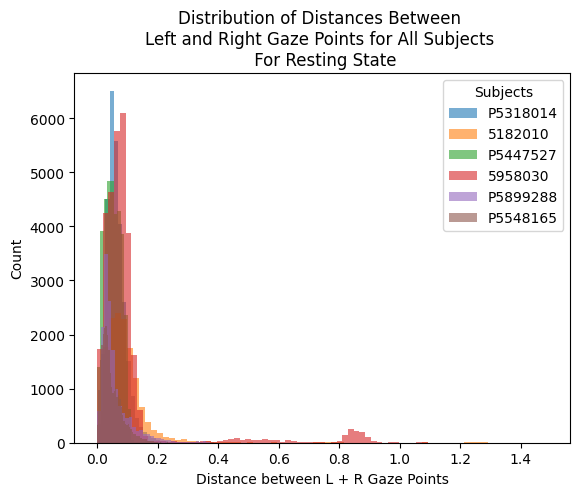

In [9]:
fig, ax = plt.subplots()
results = []

for i in range(6):
    sub_name, dmax, rest_nsamp, nsamp, srate, _ = gaze_point_histogram(i, ax=ax)  # Pass shared axes
    results.append({'input': i, 'sub_id': sub_name, 'dmax': dmax, 'rest_nsamp': rest_nsamp, 'nsamp': nsamp, 'srate': srate})

ax.legend(title = 'Subjects')
ax.set_title('Distribution of Distances Between \nLeft and Right Gaze Points for All Subjects \n For Resting State')
plt.show()

In [10]:
from pprint import pprint

pprint(results, width = 200, sort_dicts = False)

[{'input': 0, 'sub_id': 'P5318014', 'dmax': 1.0374001, 'rest_nsamp': 35998, 'nsamp': 170396, 'srate': 119.9959},
 {'input': 1, 'sub_id': '5182010', 'dmax': 1.4889534, 'rest_nsamp': 35998, 'nsamp': 137769, 'srate': 119.9958},
 {'input': 2, 'sub_id': 'P5447527', 'dmax': 0.84232503, 'rest_nsamp': 35998, 'nsamp': 300111, 'srate': 119.9959},
 {'input': 3, 'sub_id': '5958030', 'dmax': 1.4130424, 'rest_nsamp': 35999, 'nsamp': 273627, 'srate': 119.9957},
 {'input': 4, 'sub_id': 'P5899288', 'dmax': 0.87437904, 'rest_nsamp': 35998, 'nsamp': 292138, 'srate': 119.9957},
 {'input': 5, 'sub_id': 'P5548165', 'dmax': 0.34537977, 'rest_nsamp': 35999, 'nsamp': 187767, 'srate': 119.996}]
